<a href="https://colab.research.google.com/github/Danielstevends/MercyCorps_Hackathon/blob/main/HACIT_Humanitarian_Aid_Cost_Integration_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HACIT - Humanitarian Aid Cost Integration Tool



To provide the coordinates for a truck route from Cairo International Airport to the Rafah border crossing leading into Gaza, you can follow these general waypoints for the main cities and areas along the route:

- Cairo International Airport (Starting Point)
Coordinates: 30.1127° N, 31.3998° E
- Cairo (Exiting Cairo towards the Sinai Peninsula)
Coordinates: 30.0444° N, 31.2357° E
- Suez (Where the route passes near or through the city before entering the Sinai Peninsula)
Coordinates: 29.9668° N, 32.5498° E
- Al Ismailia (Midway through the Sinai Peninsula)
Coordinates: 30.5965° N, 32.2715° E
- Al Qantara East (Further along the route towards Rafah)
Coordinates: 31.1511° N, 32.5450° E
- Rafah Border Crossing (End Point)
Coordinates: 31.2871° N, 34.2501° E

This route primarily follows the main highways crossing the Sinai Peninsula, connecting to the Rafah border via major roads. For the most accurate and current route information, especially considering possible restrictions or local conditions, using a GPS or a reliable map service like Google Maps would be essential when actually planning the travel.

# 1. Initializations

Packages Declarations:

In [22]:
# Do this once and you're good
!pip install ipyleaflet --quiet
!pip install folium --quiet
!pip install googlemaps --quiet
!pip install gmplot --quiet
!pip install ipyleaflet ipywidgets --quiet
!pip install requests --quiet
!pip install telethon --quiet
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib --quiet

# !jupyter nbextension enable --py --sys-prefix gmaps

In [23]:
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
import matplotlib.pyplot as plt
import folium
import googlemaps
import pandas as pd
import itertools
import gmplot
import webbrowser
import requests
import ipywidgets as widgets
import datetime


from google.colab import output, auth
from datetime import datetime
from IPython.display import display, clear_output
from ipywidgets import IntSlider, FloatSlider, VBox, interactive_output, Layout, Text, Button
from ipywidgets import Button, HTML, VBox, Text, Label
from ipyleaflet import Map, Marker, Popup, FullScreenControl, MarkerCluster
from itertools import islice
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build

output.enable_custom_widget_manager()  # This is specific for Google Colab to enable widgets

#GoogleMaps API
API_KEY = 'YOUR_API_KEY'

#Forex API
APP_ID = 'YOUR_API_KEY'

#Gas Price API
GAS_APIKEY = 'YOUR_API_KEY'

#GoogleSheet API
CLIENT_ID = 'YOUR_API_KEY'

# Replace 'YOUR_API_KEY' with your actual Google Maps API key
gmaps = googlemaps.Client(key= API_KEY)

Function Declarations:

In [105]:
# Function to get route time and distance for different modes
def get_route_time_distance_all(client, waypoints, mode):
    results = {
        'total_distance': 0,
        'total_duration': 0,
        'distances': []
    }

    for start, end in zip(waypoints, waypoints[1:]):
        response = client.distance_matrix(
            origins=[f"{start[0]},{start[1]}"],
            destinations=[f"{end[0]},{end[1]}"],
            mode=mode
        )

        # Check if 'distance' and 'duration' are available in the response
        elements = response['rows'][0]['elements'][0]

        if 'distance' in elements and 'duration' in elements:
            distance = elements['distance']['value'] / 1000  # Convert meters to kilometers
            duration = elements['duration']['value'] / 60  # Convert seconds to minutes
            results['total_distance'] += distance
            results['total_duration'] += duration
            results['distances'].append(distance)
        else:
            print(f"No route found from {start} to {end} for mode: {mode}")
            return None

    return results

def gmaps_distance(point1, point2):
    gmaps = googlemaps.Client(key=API_KEY)  # Replace 'YOUR_API_KEY' with your actual API key
    result = gmaps.distance_matrix(point1, point2, mode='driving')
    print("Distance Matrix API Response:", result)  # Print the response for inspection

    # Check if the response contains valid data
    if 'rows' in result and len(result['rows']) > 0 and 'elements' in result['rows'][0] \
        and len(result['rows'][0]['elements']) > 0 and 'distance' in result['rows'][0]['elements'][0]:

        # Access the distance value from the response
        distance = result['rows'][0]['elements'][0]['distance']['value'] / 1000  # Distance in kilometers
        return distance
    else:
        print("Error: Unable to retrieve distance from API response.")
        return None

In [25]:
def get_route_time_distance_apiCall(client, waypoints, transit_mode):
    """
    Calculate the total travel distance and duration using a routing API, given a series of waypoints and a travel mode.

    Parameters:
    client (object): API client object configured to make requests to a distance matrix service.
    waypoints (list): List of (latitude, longitude) tuples representing the route waypoints.
    mode (str): List of travel mode (e.g., 'driving', 'walking', 'bicycling','transit').
    transit_mode: preferred modes of transit. This parameter may only be specified for transit directions.
        bus indicates that the calculated route should prefer travel by bus.
        subway indicates that the calculated route should prefer travel by subway.
        train indicates that the calculated route should prefer travel by train.
        tram indicates that the calculated route should prefer travel by tram and light rail.
        rail indicates that the calculated route should prefer travel by train, tram, light rail, and subway. This is equivalent to transit_mode=train|tram|subway.


    Returns:
    dict: A dictionary containing total distance, total duration, and a list of distances between waypoints if successful, or None if an error occurs.
    """
    results = {
        'total_distance': 0,  # Total distance in kilometers
        'total_duration': 0,  # Total duration in minutes
        'distances': [],
        'durations': []
    }


    for start, end in zip(waypoints, waypoints[1:]):
        response = client.distance_matrix(
            origins=[f"{start[0]},{start[1]}"],
            destinations=[f"{end[0]},{end[1]}"],
            mode=mode
        )

    try:
        for i, row in enumerate(response['rows']):
            element = row['elements'][i]  # Corresponding destination response
            # print(element)
            if 'distance' in element and 'duration' in element:
                distance = element['distance']['value'] / 1000  # Convert meters to kilometers
                duration = element['duration']['value'] / 60  # Convert seconds to minutes

            else:
                distance = None
                duration = None
                # raise ValueError(f"No route data available from {waypoints[i]} to {waypoints[i + 1]} for mode: {mode}")
                print(f"No route data available from {waypoints[i]} to {waypoints[i + 1]} for mode: {mode}\n")
                print(f"Calculating distance and time based on estimate parameters from database...\n")
            results['total_distance'] += distance
            results['total_duration'] += duration
            results['distances'].append(distance)
            results['durations'].append(duration)

    except KeyError:
        print("Invalid response structure received from API.")
        return None
    except ValueError as e:
        print(e)
        return None

    return results

In [26]:
# Function to create and add a draggable marker to the map with a popup
def add_draggable_marker(lat, lon, label):
    marker = Marker(location=(lat, lon), draggable=True)
    popup = Popup(location=(lat, lon), child=Text(value=label), close_button=False, auto_close=False)
    marker.popup = popup
    m.add_layer(marker)
    return marker

# Function to capture and parse coordinates on button click
def on_button_clicked(x):
    global coordinates  # Ensure it affects the global variable

    # Update the global coordinates dictionary
    for i, label in enumerate(labels):
        coordinates[label] = markers[i].location

    # Update the text widget to display the coordinates
    coord_text = ', '.join([f"{label}: ({loc[0]:.6f}, {loc[1]:.6f})" for label, loc in zip(labels, positions)])
    coordinates_display.value = coord_text
    coordinates_display.layout = Layout(width='100%', height='50px', margin='50px 0 50px 0')

In [27]:
# Function to convert geographic coordinates (lat, lon) to kilometers relative to an origin
def geo_to_km(origin, point):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1 = origin
    lat2, lon2 = point

    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)
    a = (math.sin(delta_lat/2))**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * (math.sin(delta_lon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c

    # Calculate the bearing angle
    x = math.sin(delta_lon) * math.cos(math.radians(lat2))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(delta_lon)
    bearing = math.atan2(x, y)

    # Convert bearing and distance to kilometers
    km_x = distance * math.sin(bearing)
    km_y = distance * math.cos(bearing)

    return km_x, km_y

# Calculate distances
def calculate_distance(point1, point2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Coordinates in decimal degrees
    lat1, lon1 = point1
    lat2, lon2 = point2

    # Convert decimal degrees to radians
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Haversine formula
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [28]:
def plotting_coordinates(coordinates):
  # Use the first coordinate as the origin for visualization
  origin = next(iter(coordinates.values()))
  waypoints = list(coordinates.values())
  waypoints_to_distance(coordinates)

  # Transform geographic coordinates to km relative to the origin
  km_coordinates = {label: geo_to_km(origin, coord) if coord != origin else (0, 0) for label, coord in coordinates.items()}

  # Prepare plot
  x_coords, y_coords = zip(*km_coordinates.values())
  labels = km_coordinates.keys()

  # Calculate the range of coordinates
  x_range = max(x_coords) - min(x_coords)
  y_range = max(y_coords) - min(y_coords)

  # Set the figure size based on the range of coordinates
  plt.figure(figsize=(max(6, x_range / 3), max(6, y_range / 3)))

  # Plot and label each point
  for label, (x, y) in km_coordinates.items():
      plt.scatter(x, y, s=80)
      plt.text(x, y, f' {label}', fontsize=12)

  # Draw lines between points and label distances
  for i in range(len(km_coordinates) - 1):
      label1 = list(km_coordinates.keys())[i]
      label2 = list(km_coordinates.keys())[i + 1]
      coord1 = km_coordinates[label1]
      coord2 = km_coordinates[label2]

      # Plot line between points
      plt.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'k-')

      # Calculate the midpoint of the line for annotation
      mid_x, mid_y = (coord1[0] + coord2[0]) / 2, (coord1[1] + coord2[1]) / 2
      distance = calculate_distance(waypoints[i], waypoints[i+1])  # Calculate distance from origin to current point
      plt.annotate(f'{distance:.2f} km', xy=(mid_x, mid_y), xytext=(mid_x + 0.1, mid_y + 0.1), textcoords='data', ha='center')

  plt.grid(True)
  plt.title('Geographic Points Visualization with Distances')
  plt.xlabel('Kilometers East of Origin')
  plt.ylabel('Kilometers North of Origin')
  x_min, x_max = min(x_coords), max(x_coords)
  y_min, y_max = min(y_coords), max(y_coords)
  plt.xlim(x_min - 1, x_max + 1)
  plt.ylim(y_min - 1, y_max + 1)
  plt.show()

def waypoints_to_distance(coordinates):
  # List of waypoints in order
  waypoints = list(coordinates.values())

  # Loop over waypoints to calculate distances and total distance
  distances = []  # List to store distances between consecutive waypoints
  total_distance = 0  # Variable to store the total distance

  # Iterate over the waypoints to calculate distances between consecutive points
  for i in range(len(waypoints)-1):
      # Get the current waypoint and the next waypoint (with loop back to start)
      current_point = waypoints[i]
      # next_point = waypoints[(i + 1) % len(waypoints)]  # Loop back to the first point
      next_point = waypoints[i+1]

      # Calculate the distance between consecutive waypoints
      distance = calculate_distance(current_point, next_point)
      distances.append(distance)  # Add to the list of distances
      total_distance += distance  # Add to the total distance

  # Print results
  print(f"Total loop distance: {total_distance:.2f} km")

  # Print the distance between consecutive points with labels
  for i in range(len(distances)):
      label_start = f"Point {i + 1}"
      label_end = f"Point {i + 2}"
      print(f"Distance between {label_start} and {label_end}: {distances[i]:.2f} km")

In [29]:
# Function to get coordinates from Google Maps API
def get_coordinates(api_key, address):
    url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {'address': address, 'key': api_key}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        json_response = response.json()
        if json_response['status'] == 'OK':
            result = json_response['results'][0]
            return result['geometry']['location']
        else:
            raise Exception("Geocoding API error: " + json_response['status'])
    else:
        response.raise_for_status()

# Function to collect location names and convert to coordinates
def collect_locations(api_key):
    global location_names
    num_points = int(input("How many locations would you like to enter? "))
    coordinates = {}
    for i in range(1, num_points + 1):
        while True:
            location_name = input(f"Enter the location name for point {i}: ")
            try:
                location_coords = get_coordinates(api_key, location_name)
                location_names.append(location_name)
                coordinates[f"Point {i}"] = (location_coords['lat'], location_coords['lng'])
                break
            except Exception as e:
                print(f"Error obtaining coordinates: {e}")
    return coordinates

# Function to create a map and plot the locations
def plot_locations(coordinates):
    # Check if the coordinates dictionary is empty
    if not coordinates:
        print("No valid coordinates provided.")
        # Return a default empty map centered on a generic location
        return folium.Map(location=[0, 0], zoom_start=5)

    # Assuming the first location's coordinates to center the map
    first_location = list(coordinates.values())[0]
    # Create a folium map centered around the first location
    map_obj = folium.Map(location=first_location, zoom_start=12)

    # Add markers for each coordinate point
    for label, (lat, lng) in coordinates.items():
        folium.Marker([lat, lng], popup=label).add_to(map_obj)

    return map_obj

In [30]:
##Initialization
coordinates = []
location_names = []

# Transportation modes available
supported_modes = ['Car/Truck', 'Plane']
num_vehicles = []
modes = []

# Currencies
currency_choice = ['AFN', 'ALL', 'AMD', 'ANG', 'AOA', 'ARS', 'AUD', 'AWG', 'AZN', 'BAM', 'BBD', 'BDT', 'BGN', 'BHD', 'BIF', 'BMD', 'BND', 'BOB', 'BRL', 'BSD', 'BTC', 'BTN', 'BWP', 'BYN', 'BZD', 'CAD', 'CDF', 'CHF', 'CLF', 'CLP', 'CNH', 'CNY', 'COP', 'CRC', 'CUC', 'CUP', 'CVE', 'CZK', 'DJF', 'DKK', 'DOP', 'DZD', 'EGP', 'ERN', 'ETB', 'EUR', 'FJD', 'FKP', 'GBP', 'GEL', 'GGP', 'GHS', 'GIP', 'GMD', 'GNF', 'GTQ', 'GYD', 'HKD', 'HNL', 'HRK', 'HTG', 'HUF', 'IDR', 'ILS', 'IMP', 'INR', 'IQD', 'IRR', 'ISK', 'JEP', 'JMD', 'JOD', 'JPY', 'KES', 'KGS', 'KHR', 'KMF', 'KPW', 'KRW', 'KWD', 'KYD', 'KZT', 'LAK', 'LBP', 'LKR', 'LRD', 'LSL', 'LYD', 'MAD', 'MDL', 'MGA', 'MKD', 'MMK', 'MNT', 'MOP', 'MRU', 'MUR', 'MVR', 'MWK', 'MXN', 'MYR', 'MZN', 'NAD', 'NGN', 'NIO', 'NOK', 'NPR', 'NZD', 'OMR', 'PAB', 'PEN', 'PGK', 'PHP', 'PKR', 'PLN', 'PYG', 'QAR', 'RON', 'RSD', 'RUB', 'RWF', 'SAR', 'SBD', 'SCR', 'SDG', 'SEK', 'SGD', 'SHP', 'SLL', 'SOS', 'SRD', 'SSP', 'STD', 'STN', 'SVC', 'SYP', 'SZL', 'THB', 'TJS', 'TMT', 'TND', 'TOP', 'TRY', 'TTD', 'TWD', 'TZS', 'UAH', 'UGX', 'USD', 'UYU', 'UZS', 'VES', 'VND', 'VUV', 'WST', 'XAF', 'XAG', 'XAU', 'XCD', 'XDR', 'XOF', 'XPD', 'XPF', 'XPT', 'YER', 'ZAR', 'ZMW', 'ZWL']

# Food Dataframe
food_df = pd.DataFrame()

# Employee
total_salary = 0

num_vehicles_text = widgets.IntText(value=1, description='No. Vehicles:', disabled=False)

def on_num_vehicles_text_change(change):
    global num_vehicles
    num_vehicles = change['new']

num_vehicles_text.observe(on_num_vehicles_text_change, names='value')

def collect_segments(btn):
    global num_vehicles, modes
    num_vehicles.clear()  # Clear existing data to prevent duplication
    modes.clear()         # Clear existing data to prevent duplication

    for control_group in segment_controls:
        # Append current segment's number of vehicles and mode to the lists
        num_vehicles.append(control_group.children[0].value)
        modes.append(control_group.children[1].value)

# 2. Tool Implementation

## 2.1 Select The Method of Transportation

In [31]:
# Re-Initialization
coordinates = {'Point 1': (-6.8947248, 107.6333932),
 'Point 2': (-6.9039886, 107.5799633),
 'Point 3': (-6.2653379, 106.8855528),
 'Point 4': (-6.192745299999999, 106.8940801)}

In [208]:
# Re-initialize
location_names = []

# Displaying the HTML title
display(HTML('<strong style="font-size: 32px;">Input the locations of Destination, Transit, and Final destination</strong>'))

coordinates = collect_locations(API_KEY)

# For Case Study, Gaza
# Location point 1: Amman, Jordan
# Location point 2: Queen Alia Airport
# Location point 3: El Arish Airport
# Location point 4: Rafah border Gaza

How many locations would you like to enter? 4
Enter the location name for point 1: Amman, Jordan
Enter the location name for point 2: Queen Alia Airport
Enter the location name for point 3: El Arish Airport
Enter the location name for point 4: Rafah border Gaza


Distance and Visualization of location for each Segment:

In [209]:
# Mock data: Coordinates dictionary
map_obj = plot_locations(coordinates)
map_html = map_obj._repr_html_()

# Calculate the number of segments
num_segments = len(coordinates) - 1

# Create widgets for each segment
segment_controls = []
for i in range(num_segments):
    num_vehicles_text = widgets.IntText(value=1, description=f'No. Vehicles Segment {i+1}:', disabled=False)
    mode_dropdown = widgets.Dropdown(options=supported_modes, description=f'Segment {i+1}:', disabled=False)
    segment_controls.append(widgets.VBox([num_vehicles_text, mode_dropdown]))

collect_modes_button = widgets.Button(description="Collect Modes")
collect_modes_button.on_click(collect_segments)

# Arrange widgets horizontally
left_widget = widgets.VBox(segment_controls + [collect_modes_button])
right_widget = widgets.HTML(value=f'<div style="width: 300%; height: 300%;">{map_html}</div>')

# Displaying the HTML title
display(HTML('<strong style="font-size: 32px;">Visualization of Locations Selected</strong>'))
# Using HBox to display the map and widgets side by side
display(widgets.HBox([left_widget, right_widget]))

Calculating Gas and Emissions

In [228]:
display(HTML('<strong style="font-size: 32px;">Aid Route with Fuel and Emission Calculation</strong>'))

# Define adjustable variables for 'Plane' mode
km_per_liter_plane_widget = widgets.FloatSlider(
    value=0.3,
    min=0.1,
    max=20.0,
    step=0.1,
    description='Km/L (Plane):'
)

fuel_price_plane_widget = widgets.FloatText(
    value=1.64,
    description='$/L Fuel Plane:'
)

emission_per_km_plane_widget = widgets.FloatText(
    value= 7,
    description='Emission per km (Plane):'
)

# Define adjustable variables for 'Car/Truck' mode
km_per_liter_car_widget = widgets.FloatSlider(
    value=10.0,
    min=1.0,
    max=20.0,
    step=0.1,
    description='Km/L Car/Truck:'
)

fuel_price_car_widget = widgets.FloatText(
    value=0.21,
    description='$/L Fuel Car/Truck:'
)

emission_per_km_car_widget = widgets.FloatText(
    value=3.5,
    description='Emission per km (Car/Truck):'
)


# Calculate gas price and emission based on mode
def calculate_gas_price_and_emission(distances):
    global modes
    total_gas_price = 0
    total_emission = 0

    for i in range(len(modes)):
        if modes[i] == 'Plane':
            km_per_liter = km_per_liter_plane_widget.value
            fuel_price = fuel_price_plane_widget.value
            emission_per_km = emission_per_km_plane_widget.value
        else:
            km_per_liter = km_per_liter_car_widget.value
            fuel_price = fuel_price_car_widget.value
            emission_per_km = emission_per_km_car_widget.value

        gas_price = distances[i] / km_per_liter * fuel_price * num_vehicles[i]
        emission = distances[i] * emission_per_km * num_vehicles[i]

        total_gas_price += gas_price
        total_emission += emission

    return total_gas_price, total_emission

# Function to update gas price and emission based on mode
def update_gas_price_and_emission(change):
    global gas_price, emission
    gas_price, emission = calculate_gas_price_and_emission(distances)
    gas_price_output.value = f'Gas Price: {gas_price:.2f} USD'
    emission_output.value = f'Emission: {emission:.2f} kg CO2'

# Bind the update function to mode dropdown changes
mode_dropdown.observe(update_gas_price_and_emission, 'value')
km_per_liter_plane_widget.observe(update_gas_price_and_emission, 'value')
fuel_price_plane_widget.observe(update_gas_price_and_emission, 'value')
emission_per_km_plane_widget.observe(update_gas_price_and_emission, 'value')
km_per_liter_car_widget.observe(update_gas_price_and_emission, 'value')
fuel_price_car_widget.observe(update_gas_price_and_emission, 'value')
emission_per_km_car_widget.observe(update_gas_price_and_emission, 'value')

# Initial calculation
initial_gas_price, initial_emission = calculate_gas_price_and_emission(distances)

# Display the map, waypoints/distances, and widgets
display(HTML(map_style + f'<div id="map-container">{m._repr_html_()}<div id="waypoints-container">{waypoints_html}{distances_html}</div></div>'))

display(HTML('<strong style="font-size: 20px;">Adjust Numbers for Fuel and Emission Calculation</strong>'))

display(km_per_liter_plane_widget, fuel_price_plane_widget, emission_per_km_plane_widget,
        km_per_liter_car_widget, fuel_price_car_widget, emission_per_km_car_widget,
        gas_price_output, emission_output)

FloatSlider(value=0.3, description='Km/L (Plane):', max=20.0, min=0.1)

FloatText(value=1.64, description='$/L Fuel Plane:')

FloatText(value=7.0, description='Emission per km (Plane):')

FloatSlider(value=10.0, description='Km/L Car/Truck:', max=20.0, min=1.0)

FloatText(value=0.21, description='$/L Fuel Car/Truck:')

FloatText(value=3.5, description='Emission per km (Car/Truck):')

HTML(value='Gas Price: 360.54 USD')

HTML(value='Emission: 2527.56 kg CO2')

## 2.2 Select The Aid Basket and Ingredients

## 2.2.0 API Call For Food Information

Google Spreadsheet API

In [231]:
# Authenticate the user
auth.authenticate_user()
creds = GoogleCredentials.get_application_default()

# Build the service
service = build('sheets', 'v4', credentials=creds)

# Your spreadsheet ID
SPREADSHEET_ID = '1CYUSuWbTvcINtHsDWTLdaKF7Isv9wKcyG_yYm1Ar52I'

# Specify the range of data you want to pull
RANGE_NAME = 'Sheet1'  # Update with your specific range if different

# Make the API call to fetch data
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Check if data was fetched successfully
if not values:
    print('No data found.')
else:
    # Create a DataFrame and display it
    foods = pd.DataFrame(values)
    foods.columns = foods.iloc[0]  # Set the first row as column headers
    foods = foods[1:]  # Remove the first row after setting it as the header
    #print(foods)

## 2.2.1 Calculating The Aid Basket Cost

#### 2.2.1.1 Ask for foods and amount

In [233]:
# Initialization
number_of_baskets = 0
number_of_items = 0

# Create widgets
number_of_items_widget = widgets.IntText(
    value=1,
    description='Number of items:',
    style={'description_width': 'initial'}
)

number_of_baskets_widget = widgets.IntText(
    value=1,
    description='Number of Baskets:',
    style={'description_width': 'initial'}
)

display(HTML('<strong style="font-size: 32px;">Input Items in The Aid Basket</strong>'))

submit_button = widgets.Button(description="Submit Number")
capture_button = widgets.Button(description="Capture Inputs")
foods_list = []

# Function to create dropdown for food names and quantity widgets
def create_food_widgets(num):
    global foods_list
    foods_list = []
    for i in range(num):
        food_name_dropdown = widgets.Dropdown(
            options=foods['Food'].tolist(),  # Populate dropdown with food names
            description=f'Food {i+1} Name:',
            style={'description_width': 'initial'}
        )
        food_quantity = widgets.BoundedIntText(
            value=1,
            min=1,
            description=f'Quantity:',
            style={'description_width': 'initial'}
        )
        foods_list.append((food_name_dropdown, food_quantity))
        display(food_name_dropdown, food_quantity)

# Display result
def on_submit_button_clicked(b):
    global number_of_baskets, number_of_items
    number_of_baskets = number_of_baskets_widget.value
    number_of_items = number_of_items_widget.value
    clear_output()
    display(HTML('<strong style="font-size: 32px;">Choose Items to Put Into Basket</strong>'))
    print(f"Number of Baskets: {number_of_baskets_widget.value}")
    print(f"Number of Items: {number_of_items_widget.value}")
    create_food_widgets(number_of_items_widget.value)
    display(capture_button)

submit_button.on_click(on_submit_button_clicked)

# Function to capture inputs and display them
def capture_inputs(b):
    global food_df
    food_data = []
    total_sum = 0  # To store the sum of all subtotals

    for name_widget, quantity_widget in foods_list:
        food_name = name_widget.value
        quantity = quantity_widget.value

        # Filter the DataFrame for the selected food name
        filtered_df = foods[foods['Food'] == food_name]

        # Check if the filtered DataFrame is empty
        if not filtered_df.empty:
            unit_price = int(filtered_df['Price'].values[0])  # Convert price to integer
            currency = filtered_df['Currency'].values[0]  # Assuming currency is always present
            sub_total = unit_price * quantity
            # total_sum += sub_total

            # Append data for this item to the list
            food_data.append({
                'Food': food_name,
                'Quantity': quantity,
                'Unit Price': unit_price,
                'Sub Total': sub_total,
                'Currency': currency
            })
        else:
            print(f"No data found for {food_name}")

    # Create DataFrame from the collected data
    food_df = pd.DataFrame(food_data)

    # Display the DataFrame (optional)
    display(HTML('<strong style="font-size: 18px;">Collected Food Data:</strong>'))
    display(food_df)
    # html_content = f'<strong style="font-size: 18px;">Total of all subtotals: {total_sum}</strong>'
    #display(HTML(html_content))


    # Optionally, you can return or save the DataFrame
    return food_df

# Display initial widgets
display(number_of_baskets_widget, number_of_items_widget, submit_button)

capture_button.on_click(capture_inputs)

Number of Baskets: 1300
Number of Items: 11


Dropdown(description='Food 1 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 2 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 3 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 4 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 5 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 6 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 7 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 8 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 9 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEAT…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 10 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEA…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Dropdown(description='Food 11 Name:', options=('BUCKWHEAT GRAIN', 'PASTA, MACARONI', 'FAVA BEANS', 'CANNED MEA…

BoundedIntText(value=1, description='Quantity:', min=1, style=DescriptionStyle(description_width='initial'))

Button(description='Capture Inputs', style=ButtonStyle())

2.2.1.2 Totaling the price per basket and in total based on the inputed currency

In [189]:
import datetime

target_currency = 'USD'
total = 0
total_sum = 0

def fetch_exchange_rates(date=None):
    """Fetch exchange rates using the Open Exchange Rates API for a specific or today's date."""
    if date is None:
        date = datetime.date.today()
    formatted_date = date.strftime("%Y-%m-%d")
    url = f"https://openexchangerates.org/api/historical/{formatted_date}.json"
    params = {
        'app_id': APP_ID,
        'base': 'USD'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()['rates']
    else:
        print(f"Failed to retrieve data on {formatted_date}: {response.status_code}")
        return None

def convert_currency(button):
    global food_df, target_currency, total, total_sum  # Ensure food_df is defined globally or passed appropriately
    target_currency = currency_dropdown.value
    exchange_rates = fetch_exchange_rates()
    if exchange_rates:
        # Apply the conversion to each row and create a new column for the converted subtotals
        # Convert the 'Sub Total' from its original currency to the target currency
        food_df['Sub Total (converted)'] = (food_df['Sub Total'] /
                                    food_df['Currency'].map(exchange_rates) *
                                    exchange_rates[target_currency]).round(2)

        food_df['Chosen Currency'] = target_currency
        clear_output(wait=True)
        html_content = f'<strong style="font-size: 36px;">Calculate the Basket Based on Currency</strong>'
        display(HTML(html_content))
        display(currency_dropdown, convert_button)
        display(food_df[['Food', 'Quantity', 'Unit Price', 'Sub Total', 'Currency', 'Sub Total (converted)', 'Chosen Currency']])
        total_sum = food_df['Sub Total (converted)'].sum()
        html_content = f'<strong style="font-size: 18px;">Total per Basket: {total_sum:.2f} {target_currency}</strong>'
        display(HTML(html_content))
        total = total_sum * number_of_baskets
        html_content = f'<strong style="font-size: 18px;">Total for {number_of_baskets} baskets: {total:.2f} {target_currency}</strong>'
        display(HTML(html_content))
    else:
        print("Currency conversion is not possible due to API issues.")

html_content = f'<strong style="font-size: 36px;">Calculate the Basket Based on Currency</strong>'
display(HTML(html_content))

# Assuming widget setup as before
currency_dropdown = widgets.Dropdown(
    options=currency_choice,  # Update with actual currency options
    description='Convert Currency to:',
    style={'description_width': 'initial'}
)

convert_button = widgets.Button(description="Convert Currency")
convert_button.on_click(convert_currency)
display(currency_dropdown, convert_button)

Dropdown(description='Convert Currency to:', index=148, options=('AFN', 'ALL', 'AMD', 'ANG', 'AOA', 'ARS', 'AU…

Button(description='Convert Currency', style=ButtonStyle())

,Food,Quantity,Unit Price,Sub Total,Currency,Sub Total (converted),Chosen Currency
0,"PASTA, MACARONI",5,2,10,ILS,2.69,USD
1,FAVA BEANS,3,150,450,ILS,121.06,USD
2,"OIL, SUNFLOWER, UNFORTIFIED",8,5,40,ILS,10.76,USD


2.2.1.3 Displaying the basket price based on the different timeframe as a feature to compare price

In [73]:
def fetch_exchange_rates(date=None):
    """Fetch exchange rates using the Open Exchange Rates API for a specific or today's date."""
    if date is None:
        date = datetime.date.today()
    formatted_date = date.strftime("%Y-%m-%d")
    url = f"https://openexchangerates.org/api/historical/{formatted_date}.json"
    params = {
        'app_id': APP_ID,
        'base': 'USD'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()['rates']
    else:
        print(f"Failed to retrieve data on {formatted_date}: {response.status_code}")
        return None

# Assuming you've defined your APP_ID
dates = [datetime.date.today() - datetime.timedelta(days=x) for x in range(10)]
exchange_rates = {date.strftime("%Y-%m-%d"): fetch_exchange_rates(date) for date in dates}

In [77]:
results = {}

for date, rates in exchange_rates.items():
    if rates is not None:
        # Assume 'food_df' has a 'Currency' column and a 'Sub Total' column
        food_df['Sub Total (converted)'] = (food_df['Sub Total'] /
                                            food_df['Currency'].map(rates) *
                                            rates[target_currency]).round(2)

        total_sum = food_df['Sub Total (converted)'].sum()
        results[date] = total_sum

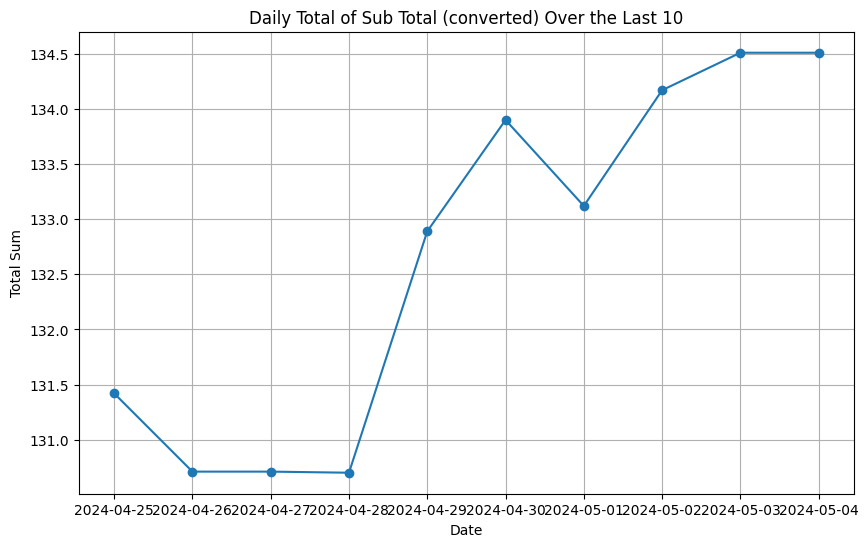

In [78]:
html_content = f'<strong style="font-size: 36px;">Visualization of Basket Price Throughout the last 10 Days</strong>'
display(HTML(html_content))


results_df = pd.DataFrame(list(results.items()), columns=['Date', 'Total Sum'])
results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Total Sum'], marker='o', linestyle='-')
plt.title('Daily Total of Sub Total (converted) Over the Last 10')
plt.xlabel('Date')
plt.ylabel('Total Sum')
plt.grid(True)
plt.show()

## 2.3 Calculation On Human Resource

In [82]:
def calculate_total_salary(employee_info):
    total_salary = 0
    for info in employee_info:
        work_hours = info['work_hours'].value
        salary_per_hour = info['salary_per_hour'].value
        days_worked = info['days_worked'].value
        total_salary += work_hours * salary_per_hour * days_worked
    return total_salary

def create_employee_widgets(num_employees):
    employee_info = []
    for i in range(num_employees):
        work_hours = widgets.FloatText(description=f'#{i+1} Hours:')
        salary_per_hour = widgets.FloatText(description=f'Hourly Wage:')
        days_worked = widgets.FloatText(description=f'Days Worked:')
        employee_widget = widgets.VBox([work_hours, salary_per_hour, days_worked])
        employee_info.append({'work_hours': work_hours, 'salary_per_hour': salary_per_hour, 'days_worked': days_worked})
        display(employee_widget)
    display(submit_button)
    return employee_info

def on_input_employees_button_clicked(b):
    num_employees = num_employees_widget.value
    global employee_info
    employee_info = create_employee_widgets(num_employees)

def on_submit_button_clicked(b):
    global total_salary
    total_salary = calculate_total_salary(employee_info)
    num_employees = len(employee_info)
    html_content = f'<strong style="font-size: 18px;">Total Salary for {num_employees} employees: ${total_salary:.2f}</strong>'
    display(HTML(html_content))

html_content = f'<strong style="font-size: 36px;">Calculate Salary for Employees to this Project</strong>'
display(HTML(html_content))

num_employees_widget = widgets.IntText(description='# Employees:')
input_employees_button = widgets.Button(description='Input Employees')
submit_button = widgets.Button(description='Calculate Total Salary')

input_employees_button.on_click(on_input_employees_button_clicked)
submit_button.on_click(on_submit_button_clicked)

display(num_employees_widget)
display(input_employees_button)

IntText(value=0, description='# Employees:')

Button(description='Input Employees', style=ButtonStyle())

Button(description='Calculate Total Salary', style=ButtonStyle())

## 2.4 All Calculations of Aid

Final Calculation on Transportation, Basket, and Human Resource/Employee:

In [188]:
total

Transportation Fuel                                            369.163516
Emission                                                        57.721008
Price per basket                                                   134.51
Number of Baskets                                                      10
Baskets Price           Transportation Fuel                           ...
Number of Employees                                                     3
Salary for Employees                                               2224.0
dtype: object

In [206]:
html_content = f'<strong style="font-size: 36px;">Summary Values to this Project</strong>'
display(HTML(html_content))


# Define the data
data = {
    'Transportation Fuel': gas_price,
    'Price per basket': total_sum,
    'Baskets Price': total,
    'Salary for Employees': total_salary,
    'TOTAL': gas_price + total + total_salary,
    'Currency': target_currency
}

data1 = {
    'Emission': emission,
    'Number of Employees': len(employee_info[0]),
    'Number of Baskets': number_of_baskets
}

# Create a DataFrame
df = pd.DataFrame(data, index=['Value'])
df_1 = pd.DataFrame(data1, index=['Value'])

# Format numbers to have two decimal places
formatted_df = df.round(2)
formatted_df_2 = df_1.round(2)


# Style the DataFrame
styled_df = formatted_df.style.set_properties(**{'text-align': 'center', 'font-weight': 'bold'}) \
                              .set_table_styles([dict(selector='th', props=[('color', 'white'),
                                                                             ('background-color', 'black'),
                                                                             ('border', '1px solid white')]),
                                                dict(selector='td', props=[('border', '1px solid white')])])

# Style the DataFrame
styled_df_2 = formatted_df_2.style.set_properties(**{'text-align': 'center', 'font-weight': 'bold'}) \
                              .set_table_styles([dict(selector='th', props=[('color', 'white'),
                                                                             ('background-color', 'black'),
                                                                             ('border', '1px solid white')]),
                                                dict(selector='td', props=[('border', '1px solid white')])])

html_content = f'<strong style="font-size: 20px;">Price Calculated</strong>'
display(HTML(html_content))

# Display the styled DataFrame
display(styled_df)


html_content = f'<strong style="font-size: 20px;">Other Metrix</strong>'
display(HTML(html_content))

# Display the styled DataFrame
styled_df_2

,Transportation Fuel,Price per basket,Baskets Price,Salary for Employees,TOTAL,Currency
Value,369.160000,134.510000,1345.100000,2224.000000,3938.260000,USD


,Emission,Number of Employees,Number of Baskets
Value,57.720000,3,10


In [173]:
len(employee_info[0])

3

# ++++++++ END +++++++++

#### Foreign Exchange API call:

source: https://openexchangerates.org/

In [86]:
# Define the URL and parameters
url = "https://openexchangerates.org/api/historical/2024-05-01.json"
params = {
    'app_id': APP_ID,  # Replace YOUR_APP_ID with your actual App ID
    'base': 'USD'
}

# Make the HTTP GET request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Access the IDR rate
    idr_rate = data['rates']['IDR']
    print(f"The exchange rate from USD to IDR on 2024-04-20 is: {idr_rate}")
else:
    print("Failed to retrieve data:", response.status_code)

The exchange rate from USD to IDR on 2024-04-20 is: 16193.6


In [42]:
# Define the URL and parameters
url = "https://openexchangerates.org/api/historical/2024-04-20.json"
params = {
    'app_id': APP_ID,  # Replace YOUR_APP_ID with your actual App ID
    'base': 'USD'
}

# Make the HTTP GET request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    display(data)
else:
    print("Failed to retrieve data:", response.status_code)

{'disclaimer': 'Usage subject to terms: https://openexchangerates.org/terms',
 'license': 'https://openexchangerates.org/license',
 'timestamp': 1713657581,
 'base': 'USD',
 'rates': {'AED': 3.6727,
  'AFN': 72,
  'ALL': 94.812793,
  'AMD': 393.233922,
  'ANG': 1.798322,
  'AOA': 837,
  'ARS': 870.106563,
  'AUD': 1.558604,
  'AWG': 1.8,
  'AZN': 1.7,
  'BAM': 1.832904,
  'BBD': 2,
  'BDT': 109.507522,
  'BGN': 1.83654,
  'BHD': 0.376978,
  'BIF': 2869,
  'BMD': 1,
  'BND': 1.362326,
  'BOB': 6.909704,
  'BRL': 5.2031,
  'BSD': 1,
  'BTC': 1.5387274e-05,
  'BTN': 83.2945,
  'BWP': 13.85877,
  'BYN': 3.265451,
  'BZD': 2.01134,
  'CAD': 1.37545,
  'CDF': 2776.433189,
  'CHF': 0.910502,
  'CLF': 0.034618,
  'CLP': 952.380952,
  'CNH': 7.25193,
  'CNY': 7.2393,
  'COP': 3919.87255,
  'CRC': 501.101033,
  'CUC': 1,
  'CUP': 25.75,
  'CVE': 103.336309,
  'CZK': 23.6995,
  'DJF': 177.686191,
  'DKK': 7.0018,
  'DOP': 59.375,
  'DZD': 134.593,
  'EGP': 48.267654,
  'ERN': 15,
  'ETB': 56.6952

#### Gas Price API call:

source: https://collectapi.com/api/gasPrice/gas-prices-api

In [19]:
# Define the URL for the API endpoint
url = "https://api.collectapi.com/gasPrice/otherCountriesGasoline"

# Define the headers including your API authorization token
headers = {
    'authorization': GAS_APIKEY,  # Replace 'your_token' with your actual API key
    'content-type': 'application/json'
}

# Make the HTTP GET request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Debugging: Print the entire response to understand its structure
    print("API Response:", data)

    # Proceed only if 'result' key exists
    if 'result' in data:
        # Filter results for Jordan and Egypt
        filtered_results = [entry for entry in data['result'] if entry['country'] in ['Jordan', 'Egypt']]
        for entry in filtered_results:
            print(f"Country: {entry['country']}, Price: ${entry['price']} per liter")
    else:
        print("The 'result' key is missing in the JSON response.")
else:
    print("Failed to retrieve data:", response.status_code)
    # Print more detailed error information if available
    if response.text:
        print("Error details:", response.text)

API Response: {'filter': 'gasoline', 'results': [{'country': 'Iran', 'price': '0.029', 'currency': 'usd'}, {'country': 'Venezuela', 'price': '0.035', 'currency': 'usd'}, {'country': 'Kuwait', 'price': '0.341', 'currency': 'usd'}, {'country': 'Angola', 'price': '0.358', 'currency': 'usd'}, {'country': 'Turkmenistan', 'price': '0.428', 'currency': 'usd'}, {'country': 'Malaysia', 'price': '0.429', 'currency': 'usd'}, {'country': 'Nigeria', 'price': '0.508', 'currency': 'usd'}, {'country': 'Bahrain', 'price': '0.531', 'currency': 'usd'}, {'country': 'Bolivia', 'price': '0.542', 'currency': 'usd'}, {'country': 'Kazakhstan', 'price': '0.551', 'currency': 'usd'}, {'country': 'Qatar', 'price': '0.577', 'currency': 'usd'}, {'country': 'Azerbaijan', 'price': '0.588', 'currency': 'usd'}, {'country': 'Oman', 'price': '0.621', 'currency': 'usd'}, {'country': 'Iraq', 'price': '0.649', 'currency': 'usd'}, {'country': 'Ecuador', 'price': '0.651', 'currency': 'usd'}, {'country': 'Sudan', 'price': '0.70

In [20]:
# Based on the inputed location

# Base URL for the API
base_url = "https://api.collectapi.com/gasPrice/fromCoordinates"

# API key header - replace 'apikey your_token' with your actual API key
headers = {
    'authorization': GAS_APIKEY,
    'content-type': 'application/json'
}

# Iterate over each point and request fuel prices
for point, (lat, lng) in coordinates.items():
    # Construct the full URL with parameters
    full_url = f"{base_url}?lat={lat}&lng={lng}"

    # Make the HTTP GET request
    response = requests.get(full_url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        print(f"Results for {point}:", data['result'])
    else:
        print(f"Failed to retrieve data for {point}:", response.status_code)
        if response.text:
            print("Error details:", response.text)

Results for Point 1: {'country': 'Indonesia', 'gasoline': '0.962', 'currency': 'usd', 'diesel': '0.995', 'date': '29-Apr-2024'}
Results for Point 2: {'country': 'Indonesia', 'gasoline': '0.962', 'currency': 'usd', 'diesel': '0.995', 'date': '29-Apr-2024'}
Results for Point 3: {'country': 'Indonesia', 'gasoline': '0.962', 'currency': 'usd', 'diesel': '0.995', 'date': '29-Apr-2024'}
Results for Point 4: {'country': 'Indonesia', 'gasoline': '0.962', 'currency': 'usd', 'diesel': '0.995', 'date': '29-Apr-2024'}


#### Weather API

In [21]:
# Base URL for the Open-Meteo API
base_url = "https://api.open-meteo.com/v1/forecast"

# Iterate over each point and request weather data
for point, (lat, lng) in coordinates.items():
    # Construct the full URL with parameters
    full_url = f"{base_url}?latitude={lat}&longitude={lng}&hourly=temperature_2m"

    # Make the HTTP GET request
    response = requests.get(full_url)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        # Print the results for this point
        print(f"Results for {point} - Hourly Temperatures:")
        # Example of accessing hourly temperature data, adjust based on actual data structure
        if 'hourly' in data and 'temperature_2m' in data['hourly']:
            for time, temp in zip(data['hourly']['time'], data['hourly']['temperature_2m']):
                print(f"{time}: {temp}°C")
        else:
            print("Temperature data not available.")
    else:
        print(f"Failed to retrieve weather data for {point}:", response.status_code)
        if response.text:
            print("Error details:", response.text)

Results for Point 1 - Hourly Temperatures:
2024-05-02T00:00: 23.6°C
2024-05-02T01:00: 25.3°C
2024-05-02T02:00: 25.9°C
2024-05-02T03:00: 26.8°C
2024-05-02T04:00: 27.8°C
2024-05-02T05:00: 28.9°C
2024-05-02T06:00: 29.6°C
2024-05-02T07:00: 29.9°C
2024-05-02T08:00: 28.4°C
2024-05-02T09:00: 27.4°C
2024-05-02T10:00: 26.3°C
2024-05-02T11:00: 25.3°C
2024-05-02T12:00: 25.4°C
2024-05-02T13:00: 25.0°C
2024-05-02T14:00: 24.6°C
2024-05-02T15:00: 24.4°C
2024-05-02T16:00: 23.9°C
2024-05-02T17:00: 23.4°C
2024-05-02T18:00: 22.9°C
2024-05-02T19:00: 22.4°C
2024-05-02T20:00: 21.9°C
2024-05-02T21:00: 21.6°C
2024-05-02T22:00: 21.3°C
2024-05-02T23:00: 21.2°C
2024-05-03T00:00: 22.4°C
2024-05-03T01:00: 24.7°C
2024-05-03T02:00: 25.8°C
2024-05-03T03:00: 27.1°C
2024-05-03T04:00: 28.2°C
2024-05-03T05:00: 29.1°C
2024-05-03T06:00: 29.2°C
2024-05-03T07:00: 28.9°C
2024-05-03T08:00: 28.3°C
2024-05-03T09:00: 27.1°C
2024-05-03T10:00: 25.9°C
2024-05-03T11:00: 24.9°C
2024-05-03T12:00: 24.5°C
2024-05-03T13:00: 24.2°C
2024-05

#### Telegram API

In [ ]:
"""
This is an example module to pull all Telegram messages from a specific Telegram channel.
"""
import os
import pandas as pd
import sys
import json
from datetime import date, datetime

from telethon import TelegramClient
from telethon.tl.functions.messages import GetHistoryRequest
from telethon.sessions import StringSession # String session is needed to generate a token that persists the connection; the string must be generated and added as an env var


class TelegramConnection:
    def __init__(self, api_id, api_hash, auth_key):
        self.api_id = api_id
        self.api_hash = api_hash
        self.auth_key = auth_key


    def pull_channel_messages(self, channel_url, fields=None):
        """
        Pull exchange rate data from an account on Telegram.
        """
        # Pull the telegram messages
        client = TelegramClient(StringSession(self.auth_key), self.api_id, self.api_hash)
        async def main():
            await client.start()

            # Connect to the telegram channel
            telegram_channel = await client.get_entity(channel_url)

            # Loop through messages in the channel and save the data in all_messages
            offset_id = total_messages = total_count_limit = 0
            all_messages = []

            while True:
                print("Pulling Telegram messages from channel: current Offset ID is:", offset_id, "; total messages:", total_messages)
                history = await client(GetHistoryRequest(peer=telegram_channel,
                                                         offset_id=offset_id,
                                                         offset_date=None,
                                                         add_offset=0,
                                                         limit=100,
                                                         max_id=0,
                                                         min_id=0,
                                                         hash=0))
                if not history.messages:
                    break
                messages = history.messages

                # Loop through the messages, select fields, and append to a list
                for message in messages:
                    message = message.to_dict()
                    if fields: message = {k: v for k, v in message.items() if k in fields}
                    all_messages.append(message)

                # Break if total required messages is reached
                offset_id = messages[len(messages) - 1].id
                total_messages = len(all_messages)
                if (total_count_limit != 0) and (total_messages >= total_count_limit):
                    break

            # Convert to a pandas DataFrame
            df_messages = pd.DataFrame(all_messages)
            return df_messages

        with client:
            df_messages = client.loop.run_until_complete(main())

        return df_messages

### Unused Codes

In [143]:
from IPython.display import HTML

display(HTML('<strong style="font-size: 32px;">Visualization of The Aid Route</strong>'))

# Calculate the center of the coordinates
center_lat = sum(lat for lat, lon in coordinates.values()) / len(coordinates)
center_lon = sum(lon for lat, lon in coordinates.values()) / len(coordinates)

# Initialize the map centered at the calculated center
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add coordinates markers and draw the route
prev_point = None
for label, point in coordinates.items():
    folium.Marker(location=point, tooltip=label).add_to(m)
    if prev_point:
        folium.PolyLine(locations=[prev_point, point], color='blue').add_to(m)
    prev_point = point

# Define custom CSS style for the map placeholder
map_style = """
    <style>
        #map-container {
            display: flex;
            flex-direction: row;
            justify-content: space-between;
            align-items: flex-start;
            width: 100%;
            height: 60%;
        }
        #waypoints-container {
            width: 40%;
            height: 100%;
            overflow-y: auto;
            padding: 10px;
            border: 1px solid #ccc;
        }
    </style>
"""

# List of waypoints in order
waypoints = list(coordinates.values())

# Loop over waypoints to calculate distances and total distance
distances = []  # List to store distances between consecutive waypoints
total_distance = 0  # Variable to store the total distance

# Iterate over the waypoints to calculate distances between consecutive points
for i in range(len(waypoints)-1):
    # Get the current waypoint and the next waypoint
    current_point = waypoints[i]
    next_point = waypoints[i + 1]

    # Calculate the distance between consecutive waypoints
    distance = calculate_distance(current_point, next_point)
    distances.append(distance)  # Add to the list of distances
    total_distance += distance  # Add to the total distance

# Build the HTML content for waypoints and distances
waypoints_html = '<h3>Waypoints</h3><ul>'
for i, (label, point) in enumerate(coordinates.items()):
    waypoints_html += f'<li><strong>{label} : ({location_names[i]})<br>Coordinate: </strong> {point}</li>'
waypoints_html += '</ul>'

distances_html = '<h3>Distances</h3><ul>'
for i, distance in enumerate(distances):
    label_start = f"Point {i + 1}"
    label_end = f"Point {i + 2}"
    distances_html += f'<li><strong>{label_start} to {label_end} with {modes[i]}:</strong> {distance:.2f} km</li>'
distances_html += f'<li><strong>Total loop distance:</strong> {total_distance:.2f} km</li>'
distances_html += '</ul>'

# Display the map and waypoints/distances
HTML(map_style + f'<div id="map-container">{m._repr_html_()}<div id="waypoints-container">{waypoints_html}{distances_html}</div></div>')

#### Food Pricing API call:

source: https://world.openfoodfacts.org/files/api-documentation.html

In [26]:
# Define the search URL
search_url = "https://world.openfoodfacts.org/cgi/search.pl"

# Define the headers with your app details
headers = {
    'User-Agent': 'NameOfYourApp - Platform - Version - www.yourappwebsite.com'
}

# Define the search parameters
params = {
    'search_terms': 'milk',  # This is the product name you're searching for
    'search_simple': '1',    # Performs a simple search, not a full-text search
    'action': 'process',
    'json': 'true',          # Ensures the response is in JSON format
    'page_size': '20'        # Number of products to return per page
}

# Make the HTTP GET request
response = requests.get(search_url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    search_results = response.json()
    # Iterate over each product and print details
    for product in search_results.get('products', []):
        print("Product Name:", product.get('product_name', 'No name available'))
        print("Brands:", product.get('brands', 'No brand available'))
        print("Quantity:", product.get('quantity', 'No quantity available'))
        print("Nutrition Grade:", product.get('nutrition_grade_fr', 'No nutrition grade available'))
        print("URL:", product.get('url', 'No URL available'))
        print("--------------------------------------------------")
else:
    print("Failed to search data:", response.status_code)

Product Name: Oat drink barista edition
Brands: Oatly
Quantity: 1 l
Nutrition Grade: e
URL: https://world.openfoodfacts.org/product/7394376616228/oat-drink-barista-edition-oatly
--------------------------------------------------
Product Name: Milka Lait Alpin
Brands: Milka,Mondelez
Quantity: 100g
Nutrition Grade: e
URL: https://world.openfoodfacts.org/product/3045140105502/milka-lait-alpin
--------------------------------------------------
Product Name: Amande sans sucre
Brands: Bjorg
Quantity: 1 l
Nutrition Grade: b
URL: https://world.openfoodfacts.org/product/3229820787015/amande-sans-sucre-bjorg
--------------------------------------------------
Product Name: Salakis 100% Brebis
Brands: Salakis,Lactalis
Quantity: 200 g
Nutrition Grade: d
URL: https://world.openfoodfacts.org/product/3023260030928/salakis-100-brebis
--------------------------------------------------
Product Name: Carré frais
Brands: Elle & Vire,Savencia
Quantity: 200 g
Nutrition Grade: d
URL: https://world.openfoodfac